### Reference
https://www.youtube.com/watch?v=8N-nM3QW7O0<br>
https://www.youtube.com/watch?v=Hnvb9b7a_Ps&t=19s<br>
https://leemeng.tw/attack_on_bert_transfer_learning_in_nlp.html<br>
https://huggingface.co/transformers

### Download dataset from kaggle

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload() 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle competitions list
! kaggle competitions download -c 'nlp-getting-started'  # Disaster Tweets
!unzip nlp-getting-started.zip

### import library

In [ ]:
! pip install transformers

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup
from torch import nn, optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from collections import defaultdict
import time
import datetime
import re

In [3]:
# set random seed
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

### check GPU is available or not, if yes use GPU  (PyTorch)

In [4]:
if torch.cuda.is_available():    
  
    device = torch.device("cuda")

    print(torch.cuda.device_count())

    print(torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    device = torch.device("cpu")

1
Tesla T4


### Read dataset

In [5]:
df = pd.read_csv('train.csv')
df_sub = pd.read_csv('test.csv')

In [6]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_sub.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Preprocessing data

In [8]:
def clean_data(text):
    text = re.sub('#','',text)
    text = re.sub('\n','',text)
    text = re.sub('http.[^\s]*','',text)
    text = re.sub('@.[^\s]*','',text)
    return text

In [9]:
df['text'] = df.text.apply(clean_data)
df_sub['text'] = df_sub.text.apply(clean_data)

In [10]:
# Download pretrained weight
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

### [test] Apply tokenizer to single sentence



> tokenizer -> return dict keys=\['input_ids','token_type_ids','attention_mask']<br> 
> tokenizer.encode -> only return token ids<br> 
> tokenizer.tokenize -> only return tokens<br>
> tokenizer.encode -> input ids return tokens<br>
> tokenizer.encode_plus -> can add attention_mask or token_type_ids to dict <br>


In [11]:
encoding = tokenizer.encode_plus(
           df.loc[1,'text'],
           max_length=512,
           add_special_tokens=True,
           padding='max_length',
           truncation = True,
           return_attention_mask=True,
           return_token_type_ids=False,
           return_tensors='pt')

In [12]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [13]:
encoded_input = tokenizer(df.loc[0,'text'])  
encoded_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [14]:
tokenizer.decode(encoded_input["input_ids"])  #special tokens added

'[CLS] Our Deeds are the Reason of this earthquake May ALLAH Forgive us all [SEP]'

### Choose max_length

In [15]:
all_len = []
for text in df.text:
    token_ids = tokenizer.encode(text,max_length=512,truncation=True)
    all_len.append(len(token_ids))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


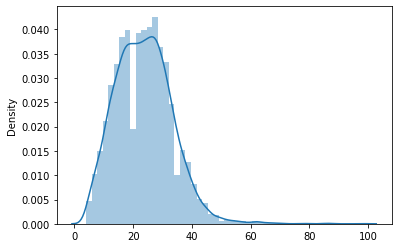

In [16]:
sns.distplot(all_len) # choose max_length : 90

In [17]:
df.shape

(7613, 5)

In [19]:
df_train, df_test = train_test_split(df, random_state=random_seed, test_size=0.3)
df_val, df_test = train_test_split(df_test, random_state=random_seed, test_size=0.5)

In [20]:
df_train.shape, df_val.shape, df_test.shape

((5329, 5), (1142, 5), (1142, 5))

### Create PyTorch Dataloader

create dataset -> turn into dataloader


In [21]:
class text_dataset(Dataset):
    
    def __init__(self, text, tokenizer, max_len, train=True, targets=None):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.train = train
        
    def __len__(self):
        return len(self.text) 
    
    def __getitem__(self,index):  #how to load data
        text = str(self.text[index])
        
        encoding = tokenizer.encode_plus(
                  text,
                  max_length=self.max_len,
                  add_special_tokens=True,
                  padding='max_length',
                  truncation = True,
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  return_tensors='pt')
        
        if self.train == True:
            target = self.targets[index]
            return {
                'text' : text,
                'input_ids' : encoding['input_ids'].flatten(),  #collapsed into one dimension
                'attention_mask' : encoding['attention_mask'].flatten(),  
                'targets' : torch.tensor(target,dtype=torch.long)
                }
    
        else:
            return {
              'text' : text,
              'input_ids' : encoding['input_ids'].flatten(),
              'attention_mask' : encoding['attention_mask'].flatten(),
              }   

In [22]:
def create_data_loader(df, tokenizer, max_len, batch_size, train=True):
    if train == True:
        dataset = text_dataset(
                    text = df.text.values, 
                    targets = df.target.values,
                    tokenizer = tokenizer, 
                    max_len = max_len,
                    train = train
                    )
    else:
        dataset = text_dataset(
                    text = df.text.values,
                    tokenizer = tokenizer, 
                    max_len = max_len,
                    train = train
                    )
    
    return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=2)   

In [23]:
MAX_LEN = 90
BATCH_SIZE = 16

In [24]:
train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)

In [25]:
sub_data_loader = create_data_loader(df_sub,tokenizer,MAX_LEN,BATCH_SIZE,train=False)

In [26]:
#check dataloader shape
data = next(iter(train_data_loader))

In [27]:
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 90])
torch.Size([16, 90])
torch.Size([16])


In [28]:
#check dataloader shape
data = next(iter(sub_data_loader))

In [29]:
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)

dict_keys(['text', 'input_ids', 'attention_mask'])
torch.Size([16, 90])
torch.Size([16, 90])


### Fine-tuning a pretrained model (classification)

https://huggingface.co/transformers/model_doc/bert.html

In [30]:
bert_model = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
# test bert_model
output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'])

In [59]:
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [60]:
print(output['last_hidden_state'].shape)  # batch_size / len of text / embedding-size
print(output['pooler_output'].shape)

torch.Size([1, 512, 768])
torch.Size([1, 768])


### Use BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", 
    num_labels = 2, # output => 2 classes
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

# BertForSequenceClassification return loss(when label is provided -> optional), logits 

# run this model on the GPU.
model.cuda()  # or model = model.to(device)

In [32]:
print("""name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))

name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=2, bias=True)


In [33]:
epochs = 4

# training steps = number of batches * number of epochs.
total_steps = len(train_data_loader) * epochs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Create the learning rate scheduler. (handle learning rate decay)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                        num_warmup_steps = 0, 
                        num_training_steps = total_steps)

In [71]:
type(optimizer)

transformers.optimization.AdamW

In [34]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [35]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [36]:
def train_model(model, train_data_loader, optimizer, device, scheduler):
    model.train()
    start_time = time.time()
    total_loss, total_accuracy = 0, 0 # reset loss and accuracy every epoch

    for step, batch in enumerate(train_data_loader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - start_time)
                
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_data_loader), elapsed))

        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['targets'].to(device)

        model.zero_grad() # set the gradients to zero before backpropragation 

        outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask, 
                labels=b_labels)
        
        loss = outputs.loss #outputs[0]
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)            
        total_accuracy += tmp_eval_accuracy
        total_loss += loss.item()        


        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # prevent "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Update parameters.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()


    avg_train_loss = total_loss / len(train_data_loader)           
    avg_train_accuracy = total_accuracy / len(train_data_loader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Accuracy: {0:.2f}".format(avg_train_accuracy))
    print("  Training epcoh took: {:}".format(format_time(time.time() - start_time)))

    return avg_train_loss, avg_train_accuracy

In [37]:
def eval_model(model, data_loader, device):

    model = model.eval()
    start_time = time.time()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():
        for d in data_loader:
            b_input_ids = d["input_ids"].to(device)
            b_input_mask = d["attention_mask"].to(device)
            b_labels = d["targets"].to(device)

            outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      labels=b_labels)
            
            loss = outputs.loss
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_loss += loss.item()
        
           
        avg_eval_accuracy = eval_accuracy / len(data_loader)
        avg_eval_loss = eval_loss / len(data_loader)

        print("  Accuracy: {0:.4f}".format(avg_eval_accuracy))
        print("  Validation took: {:}".format(format_time(time.time() - start_time)))
        
        return avg_eval_loss, avg_eval_accuracy 

In [38]:
# Store the average loss and accuracy after each epoch so we can plot them.

history = defaultdict(list)
best_accuracy = 0

for epoch in range(epochs):
    # Training step
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')

    train_loss, train_acc = train_model(model, train_data_loader, optimizer, device, scheduler)

    # Validation
    # ========================================

    print("")
    print("Running Validation...")

    val_loss, val_acc = eval_model(model, val_data_loader, device)

    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    50  of    334.    Elapsed: 0:00:13.
  Batch   100  of    334.    Elapsed: 0:00:26.
  Batch   150  of    334.    Elapsed: 0:00:39.
  Batch   200  of    334.    Elapsed: 0:00:52.
  Batch   250  of    334.    Elapsed: 0:01:05.
  Batch   300  of    334.    Elapsed: 0:01:18.

  Average training loss: 0.47
  Accuracy: 0.79
  Training epcoh took: 0:01:27

Running Validation...
  Accuracy: 0.8281
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    50  of    334.    Elapsed: 0:00:14.
  Batch   100  of    334.    Elapsed: 0:00:27.
  Batch   150  of    334.    Elapsed: 0:00:41.
  Batch   200  of    334.    Elapsed: 0:00:55.
  Batch   250  of    334.    Elapsed: 0:01:09.
  Batch   300  of    334.    Elapsed: 0:01:23.

  Average training loss: 0.33
  Accuracy: 0.87
  Training epcoh took: 0:01:32

Running Validation...
  Accuracy: 0.8281
  Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...
  Batch    

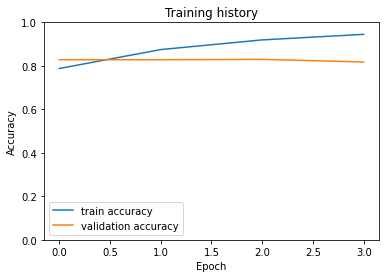

In [39]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

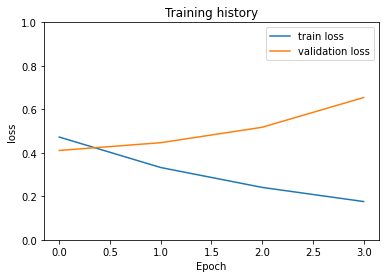

In [40]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation

In [ ]:
model = model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", 
    num_labels = 2,  
    output_attentions = False, 
    output_hidden_states = False,
)
model.load_state_dict(torch.load('best_model_state.bin'))
model.cuda()  # or model = model.to(device)

In [42]:
def get_predictions(model, data_loader, target=True):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        if target == True:
            for d in data_loader:
                b_texts = d["text"]
                b_input_ids = d["input_ids"].to(device)
                b_input_mask = d["attention_mask"].to(device)
                b_labels = d["targets"].to(device)

                outputs = model(
                  input_ids=b_input_ids,
                  attention_mask=b_input_mask
                )
                logits = outputs.logits
                _, b_preds = torch.max(logits, dim=1)
                b_probs = F.softmax(logits, dim=1)

                review_texts.extend(b_texts)
                predictions.extend(b_preds)
                prediction_probs.extend(b_probs)
                real_values.extend(b_labels)

            predictions = torch.stack(predictions).cpu()
            prediction_probs = torch.stack(prediction_probs).cpu()
            real_values = torch.stack(real_values).cpu()

            return review_texts, predictions, prediction_probs, real_values


        else:
            for d in data_loader:

                b_texts = d["text"]
                b_input_ids = d["input_ids"].to(device)
                b_input_mask = d["attention_mask"].to(device)

                outputs = model(
                  input_ids=b_input_ids,
                  attention_mask=b_input_mask
                )
                logits = outputs.logits
                _, b_preds = torch.max(logits, dim=1)
                b_probs = F.softmax(logits, dim=1)

                review_texts.extend(b_texts)
                predictions.extend(b_preds)
                prediction_probs.extend(b_probs)

            predictions = torch.stack(predictions).cpu()
            prediction_probs = torch.stack(prediction_probs).cpu()

            return review_texts, predictions, prediction_probs

In [51]:
texts, predictions, prediction_probs, target = get_predictions(model, test_data_loader, target=True)

In [52]:
print(classification_report(df_test.target, predictions, target_names=['Non_disaster','disaster'] ))

              precision    recall  f1-score   support

Non_disaster       0.83      0.86      0.85       635
    disaster       0.82      0.78      0.80       507

    accuracy                           0.83      1142
   macro avg       0.83      0.82      0.82      1142
weighted avg       0.83      0.83      0.83      1142



In [54]:
df_pred = pd.DataFrame(
    {'text': texts,
     'target': target,
     'prediction': predictions,
     'prob': torch.max(prediction_probs,1).values
    })
df_pred.head()

,text,target,prediction,prob
0,Mega mood swing on a 24 hr schedule. Isn't t...,0,0,0.968840
1,Picking up flattened hay men ( in Wahpeton ND),0,0,0.746116
2,52.214904 5.139055 Nuke please. Target Hilvers...,1,1,0.973733
3,Lose bus card.Panic.Kind bus driver.Replace bu...,0,0,0.942517
4,lol. U got wrecked,0,0,0.978289


In [56]:
df_pred.loc[df_pred.target!= df_pred.prediction]

,text,target,prediction,prob
6,Who is bringing the tornadoes and floods. Who ...,0,1,0.992072
7,Two hours to get to a client meeting. Whirlwin...,1,0,0.974934
20,Wall of noise is one thing - but a wall of dus...,1,0,0.903317
38,listen to hurricane,1,0,0.769639
40,Diaporama : sixpenceee: Karymsky Lake is a cra...,0,1,0.812239
...,...,...,...,...
1118,what tribal Olap world pres: How To Recognize...,0,1,0.931039
1124,I feel like accidents are just drawn to you b...,0,1,0.683352
1129,America like South Africa is a traumatised sic...,0,1,0.690882
1130,This liberal compassion is BS. A specific Fe...,0,1,0.975793


In [57]:
texts, predictions, prediction_probs = get_predictions(model, sub_data_loader, target=False)

In [58]:
df_ = pd.DataFrame(
    {'text': texts,
     'prediction': predictions,
     'prob': torch.max(prediction_probs,1).values
    })
df_.head()

,text,prediction,prob
0,Just happened a terrible car crash,1,0.996460
1,"Heard about earthquake is different cities, st...",1,0.994308
2,"there is a forest fire at spot pond, geese are...",1,0.995462
3,Apocalypse lighting. Spokane wildfires,1,0.997837
4,Typhoon Soudelor kills 28 in China and Taiwan,1,0.998594


In [60]:
df_ans = pd.concat([df_,df_sub],axis=1)

In [66]:
df_ans = df_ans[['id','prediction']]
df_ans.columns = ['id','target']

In [69]:
df_ans.to_csv('submission_cased.csv',index=False)

In [67]:
df_ans.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
